# 제목

## #01. 패키지 준비하기

In [1]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler

## #02. 데이터셋 준비하기

In [2]:
origin = read_excel("https://data.hossam.kr/F02/fish2.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


## #03. 데이터 전처리

### 결측치 확인

In [3]:
origin.isna().sum()

길이    0
높이    0
두께    0
무게    0
dtype: int64

## #04. 탐색적 데이터 분석

### 기본통계 확인

In [4]:
origin.describe()

,길이,높이,두께,무게
count,56.000000,56.000000,56.000000,56.000000
mean,27.892857,7.862143,4.745536,382.239286
std,9.021668,2.878343,1.775006,347.617717
min,8.400000,2.110000,1.410000,5.900000
25%,21.825000,5.690000,3.520000,120.000000
50%,25.300000,6.920000,4.155000,207.500000
75%,36.625000,10.850000,6.450000,692.500000
max,44.000000,12.800000,8.140000,1100.000000


> 평균값의 차이가 크기 때문에 표준화가 필요해 보인다.

### 상자그림

In [5]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

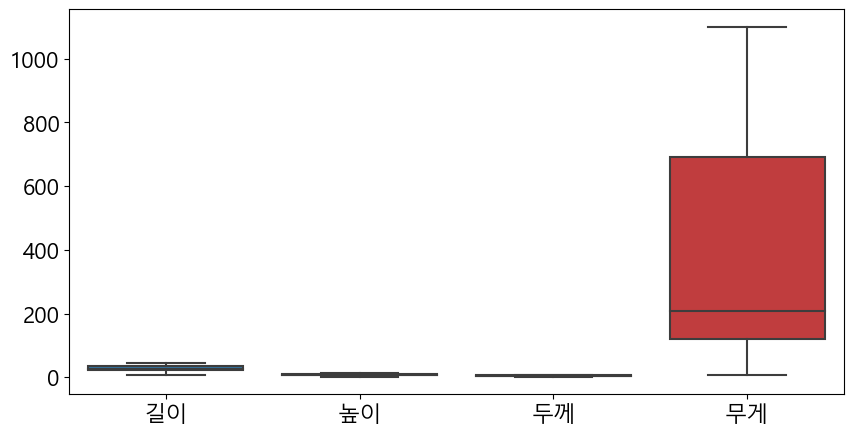

In [6]:
plt.figure(figsize=(10, 5))
sb.boxplot(data=origin)
plt.show()
plt.close()

> 데이터의 분포가 상이하므로 표준화가 필요해 보인다.

### 산점도 그래프와 추세선 확인

c:\Users\leekh\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3000x3000 with 0 Axes>

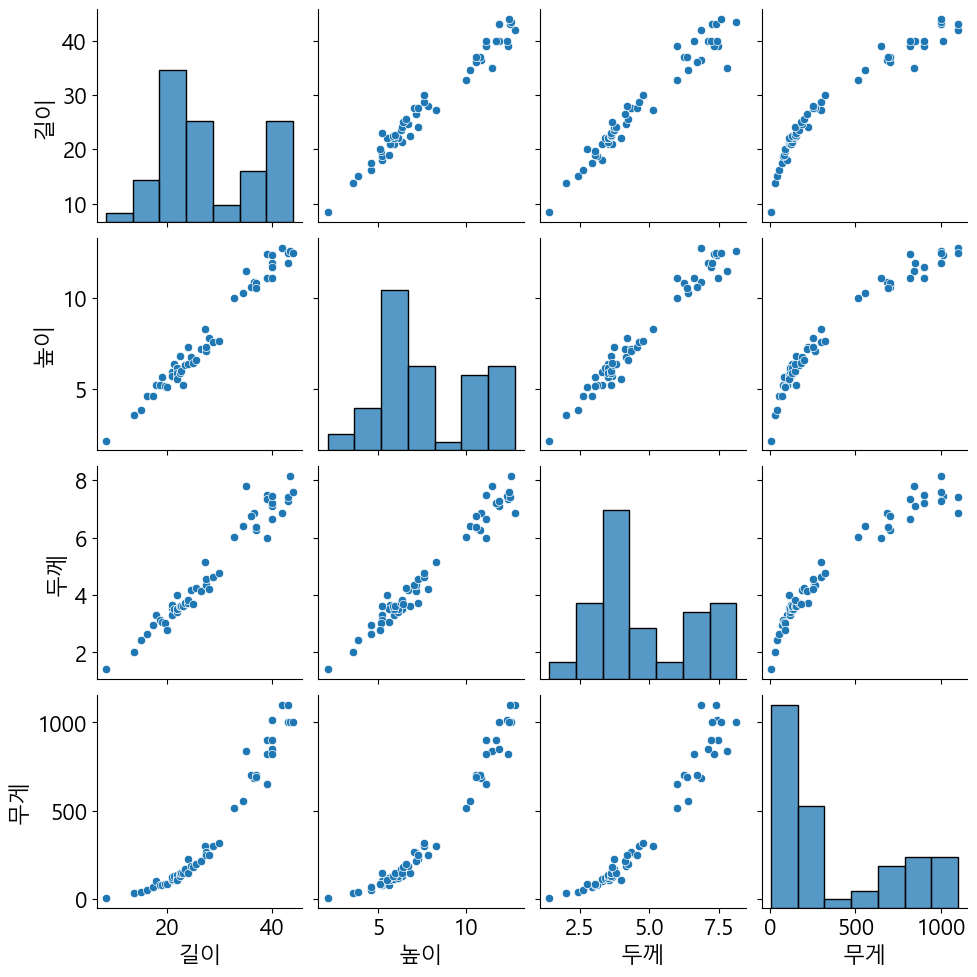

In [7]:
plt.figure(figsize=(30, 30))
sb.pairplot(origin)
plt.show()
plt.close()

> 다중공선성이 발생할 것으로 보이고, 선형회귀보다는 다항회귀가 더 적합해 보이지만 예제를 위해 다항선형회귀로 진행하기로 함

## #05. 데이터셋 분할하기

### 랜덤시드 고정

실험의 재현성 확보. 데이터 분할, 초기 가중치 설정, 교차 검증 시 데이터 섞기 등을 항상 똑같이 하기 위해서

In [8]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [9]:
x = origin[['길이','높이','두께']]
y = origin[['무게']]
x.shape, y.shape

((56, 3), (56, 1))

### 데이터 표준화

StandardScaler는 데이터의 스케일(평균과 표준 편차)을 조정하여 데이터를 표준 정규 분포(평균 0, 표준 편차 1)로 변환

fit_transform: fit 메서드를 사용하여 데이터에 대한 평균과 표준 편차를 계산하고, 그 값을 사용하여 데이터를 변환

In [10]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)
 
y_scaller = StandardScaler()
y_scale = y_scaller.fit_transform(y)

x_scale.shape, y_scale.shape

((56, 3), (56, 1))

### 표준화 전 후 상자그림 비교

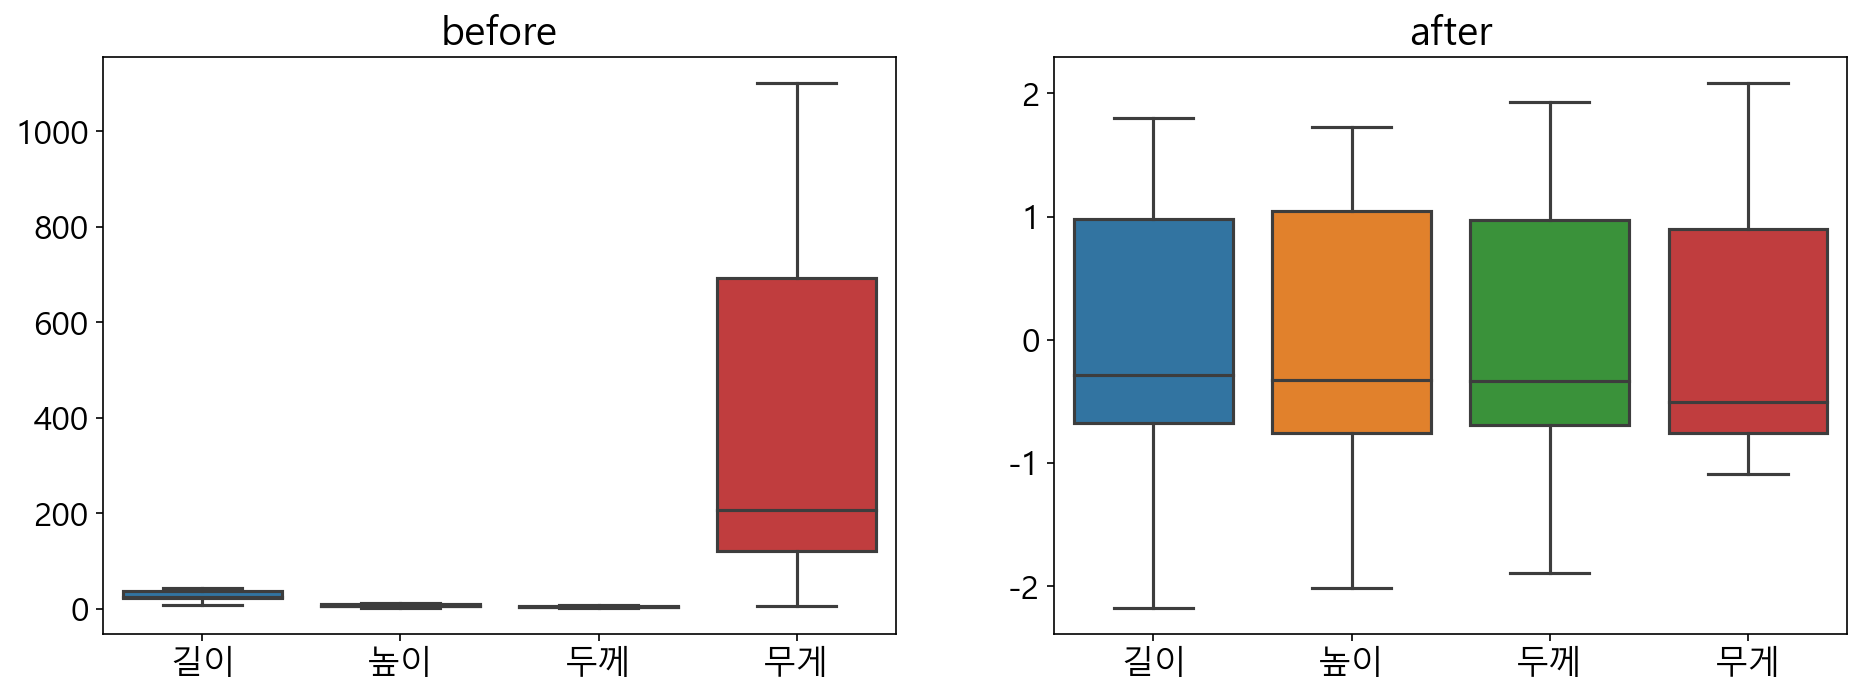

In [11]:
# 임시로 독립변수와 종속변수를 하나의 DataFrame으로 병합
x_scale_df = DataFrame(x_scale, columns=['길이','높이','두께'])
y_scale_df = DataFrame(y_scale, columns=['무게'])
tmp = merge(x_scale_df, y_scale_df, left_index=True, right_index=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
sb.boxplot(data=origin, ax=ax[0])
sb.boxplot(data=tmp, ax=ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()

### 훈련 데이터와 검증 데이터로 분할

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 3), (17, 3), (39, 1), (17, 1))

## #06. 모델 개발

### 모델 정의

데이터가 단순하고 개수가 적다면 과대적합이 발생할 확률이 높기 때문에 주의하면서 적절한 크기의 모델층을 쌓아야 한다.

배열을 1차원 배열로 변환하여 입력층을 생성하는 작업, 은닉층의 개수를 정하고 생성하는 작업, 각 은닉층별 노드의 개수를 정하는 작업, 활성화 함수를 설정하는 작업이 포함된다. 


In [13]:
#  Sequential 함수를 사용하여 모델을 생성할 때에는 한 개의 입력과 한 개의 출력이 있는 경우 각 층을 선형적으로 실행할 경우에 적합하다. 입력이나 출력이 여러개이고 은닉층을 공유하거나 분기할 경우에는 Sequential 모델이 적합하지 않다. 

model = Sequential() 


# Dense(은닉층 노드의 개수)
# Dense 함수는 은닉층과 출력층을 생성하는 역할을 하며 ()안에는 은닉층 노드의 개수, activation 활성화 함수 명을 작성함으로써 은닉층 노드의 개수와 활성화 함수를 설정한다. 분류 모델에서는 렐루, 출력층의 활성화 함수는 소프트 맥스를 사용한다. 
# 노드의 개수가 너무 많으면 훈련 데이터에 과적합이 발생할 수 있다. 

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train[0]), ))) 
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [14]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

# 모델객체.fit(훈련데이터, 훈련데이터의 레이블, epochs = 반복학습횟수)


Epoch 1/500
2/2 [==============================] - 1s 167ms/step - loss: 0.9554 - mae: 0.8930 - val_loss: 0.6311 - val_mae: 0.7294 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 29ms/step - loss: 0.7654 - mae: 0.8033 - val_loss: 0.4946 - val_mae: 0.6493 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 30ms/step - loss: 0.6018 - mae: 0.7142 - val_loss: 0.3823 - val_mae: 0.5724 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 29ms/step - loss: 0.4600 - mae: 0.6241 - val_loss: 0.2899 - val_mae: 0.4971 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 29ms/step - loss: 0.3454 - mae: 0.5436 - val_loss: 0.2155 - val_mae: 0.4217 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 29ms/step - loss: 0.2496 - mae: 0.4653 - val_loss: 0.1595 - val_mae: 0.3653 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 27ms/step - loss: 0.1820 - mae: 0.3958 - val_loss: 0.1206 - val_mae: 0.3262 - lr: 0.001

## #07. 학습 결과 평가

In [15]:
# 학습결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,0.955380,0.892971,0.631104,0.729352,0.001
2,0.765371,0.803333,0.494642,0.649280,0.001
3,0.601753,0.714166,0.382311,0.572385,0.001
4,0.460046,0.624085,0.289912,0.497083,0.001
5,0.345368,0.543603,0.215527,0.421679,0.001
6,0.249616,0.465334,0.159517,0.365265,0.001
7,0.182028,0.395782,0.120596,0.326220,0.001
8,0.129534,0.330052,0.095864,0.295966,0.001
9,0.095763,0.281835,0.081831,0.279068,0.001


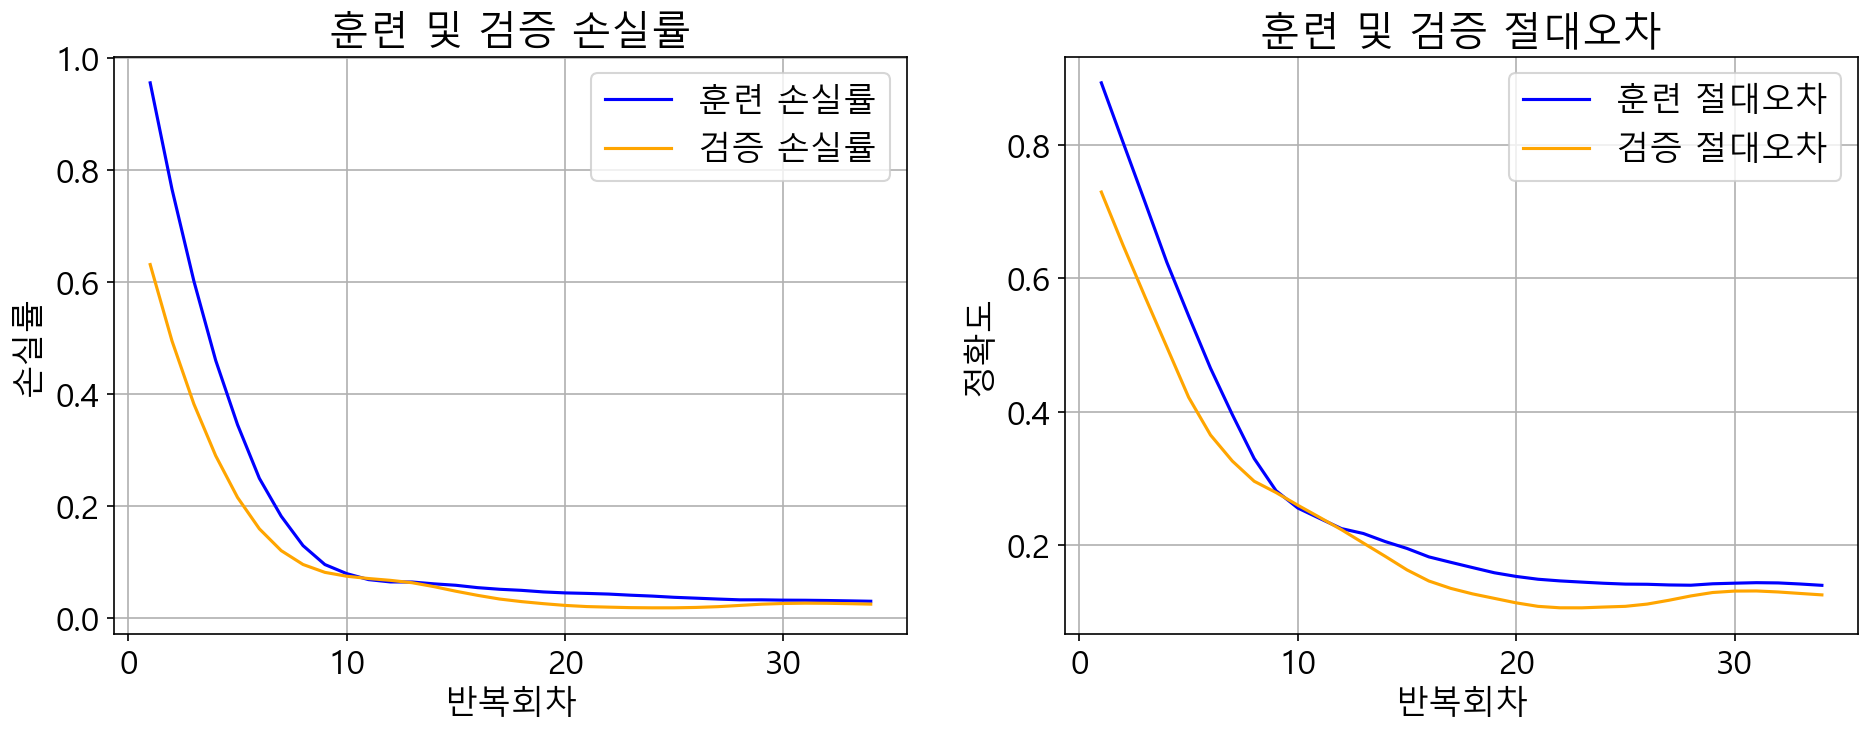

In [16]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [17]:

# evaluate() 
# 모델객체.evaluate(테스트데이터, 테스트데이터의 레이블)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 4ms/step - loss: 0.0295 - mae: 0.1382
최종 훈련 손실률: 0.029533, 최종 훈련 절대오차: 0.138241
1/1 [==============================] - 0s 21ms/step - loss: 0.0251 - mae: 0.1257
최종 검증 손실률: 0.025131, 최종 검증 절대오차: 0.125686


## #08. 학습 결과 적용

### 예측 결과 산정

In [42]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 19ms/step


### 결과 데이터 셋 구성

In [45]:
# Faltten() 함수는 다차원 배열을 1차원 배열로 만드는 역할을 하고 () 안에 input_shape를 통해 입력한 배열은 1차원으로 변환된다. 

train_df = DataFrame(x_train, columns=['길이','높이','두께'])
train_df['무게(관측치)'] = y_train.flatten()
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)']-train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-0.927534,-0.954292,-0.969558,-0.862814,-0.807211,-0.055602
1,-2.180225,-2.016507,-1.896175,-1.092422,-1.492224,0.399802
2,-0.659101,-0.779008,-0.696689,-0.761217,-0.661241,-0.099976
3,-0.368297,-0.396891,-0.327179,-0.563830,-0.446955,-0.116874
4,1.577847,1.731046,1.207709,2.083485,1.712693,0.370792


In [46]:
test_df = DataFrame(x_test, columns=['길이','높이','두께'])
test_df['무게(관측치)'] = y_test.flatten()
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)']-test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-0.659101,-0.614242,-0.696689,-0.732189,-0.623154,-0.109036
1,-0.770948,-0.761480,-0.611417,-0.746703,-0.672200,-0.074503
2,-0.580807,-0.670333,-0.634156,-0.688648,-0.608728,-0.079920
3,-0.043940,-0.204080,-0.099788,-0.383859,-0.259180,-0.124679
4,0.235678,-0.084887,0.013907,-0.180666,-0.008155,-0.172511


### 실제 결과값과 머신러닝에 의한 예측값 비교

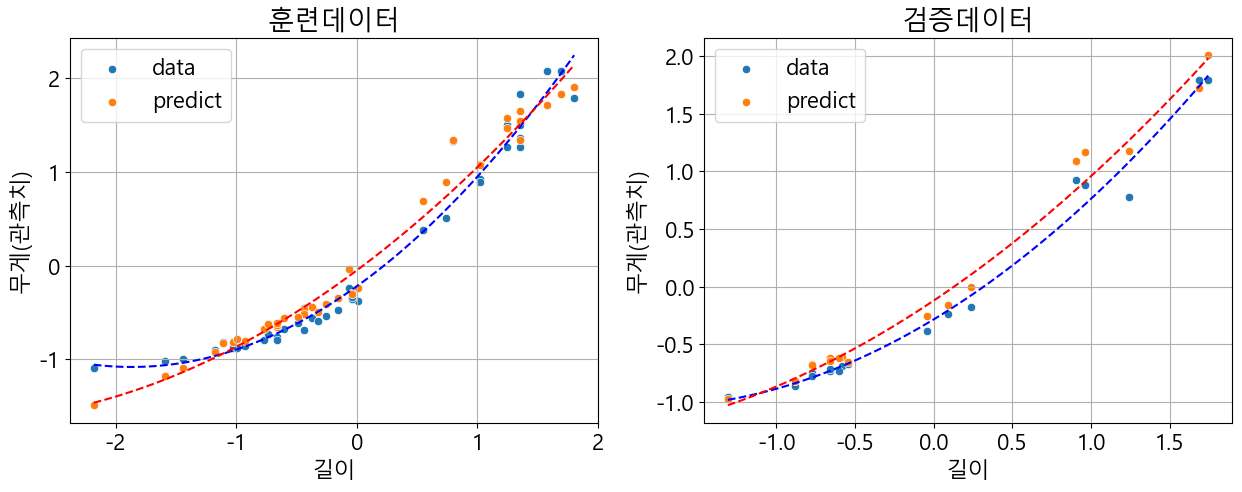

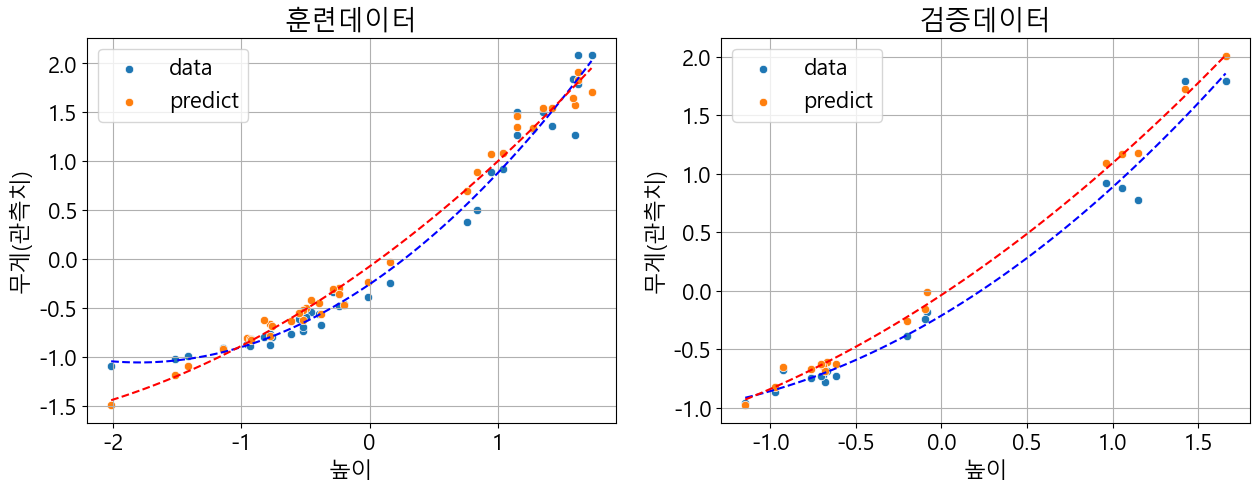

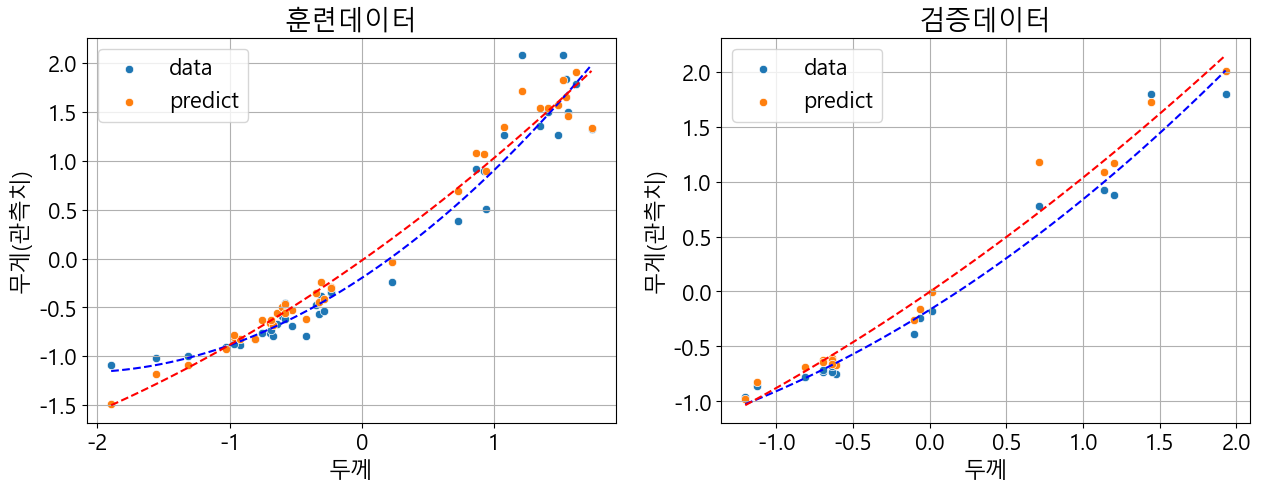

In [48]:
for key in ['길이','높이','두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))